# BME 231 Final Project - AI Diagnosis Assistant
**Name: Yerin Kang, Hajin Ruy**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

## Data Exploration

In [320]:
# import the data
df = pd.read_csv('data/Disease_symptom_and_patient_profile_dataset.csv')

df.head()

,Disease,Fever,Cough,Fatigue,Difficulty Breathing,Age,Gender,Blood Pressure,Cholesterol Level,Outcome Variable
0,Influenza,Yes,No,Yes,Yes,19,Female,Low,Normal,Positive
1,Common Cold,No,Yes,Yes,No,25,Female,Normal,Normal,Negative
2,Eczema,No,Yes,Yes,No,25,Female,Normal,Normal,Negative
3,Asthma,Yes,Yes,No,Yes,25,Male,Normal,Normal,Positive
4,Asthma,Yes,Yes,No,Yes,25,Male,Normal,Normal,Positive


In [321]:
# explore the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349 entries, 0 to 348
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Disease               349 non-null    object
 1   Fever                 349 non-null    object
 2   Cough                 349 non-null    object
 3   Fatigue               349 non-null    object
 4   Difficulty Breathing  349 non-null    object
 5   Age                   349 non-null    int64 
 6   Gender                349 non-null    object
 7   Blood Pressure        349 non-null    object
 8   Cholesterol Level     349 non-null    object
 9   Outcome Variable      349 non-null    object
dtypes: int64(1), object(9)
memory usage: 27.4+ KB


In [322]:
print("shape:", df.shape)
print("columns:", df.columns)
print("dtypes:\n", df.dtypes) # 1 numeric feature, 9 categorical features (in)

shape: (349, 10)
columns: Index(['Disease', 'Fever', 'Cough', 'Fatigue', 'Difficulty Breathing', 'Age',
       'Gender', 'Blood Pressure', 'Cholesterol Level', 'Outcome Variable'],
      dtype='object')
dtypes:
 Disease                 object
Fever                   object
Cough                   object
Fatigue                 object
Difficulty Breathing    object
Age                      int64
Gender                  object
Blood Pressure          object
Cholesterol Level       object
Outcome Variable        object
dtype: object


## Data Cleaning

In [323]:
# check for missing values
df.isnull().sum() # no missing values found

Disease                 0
Fever                   0
Cough                   0
Fatigue                 0
Difficulty Breathing    0
Age                     0
Gender                  0
Blood Pressure          0
Cholesterol Level       0
Outcome Variable        0
dtype: int64

In [324]:
# Filter positive cases
df = df[df['Outcome Variable'] == 'Positive'] # we only want positive cases for this project as we are interested in prediciting the disease
df = df.drop(columns=['Outcome Variable']) # drop the outcome variable column after filtering
print("new shape after filtering positive cases:", df.shape)

new shape after filtering positive cases: (186, 9)


In [325]:
# check for duplicates
duplicates = df.duplicated().sum()
print("number of duplciates:", duplicates)

# drop duplicates if any
df.drop_duplicates(inplace=True)
print("new shape after dropping duplicates:", df.shape)

number of duplciates: 29
new shape after dropping duplicates: (157, 9)


In [326]:
# exclude outliers for numerical features (which is Age in this case)
Q1, Q3 = df['Age'].quantile(0.25), df['Age'].quantile(0.75)
IQR = Q3 - Q1

# Identify outliers
outliers = df[(df['Age'] < Q1 - 1.5 * IQR) | (df['Age'] > Q3 + 1.5 * IQR)]
print("number of outliers", len(outliers)) # 1 outlier found

# remove outliers
df_cleaned = df[(df['Age'] >= Q1 - 1.5 * IQR) & (df['Age'] <= Q3 + 1.5 * IQR)]
print("new shape after removing outliers:", df_cleaned.shape)

number of outliers 1
new shape after removing outliers: (156, 9)


## Feature Selection and Splitting Data

In [327]:
# set feature and target variables
X = df.drop(columns=['Disease'])
y = df['Disease']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Preprocessing Pipelines

In [328]:
np.random.seed(42)

In [329]:
# nominal categorical features
nominal_cols = ['Fever', 'Cough', 'Fatigue', 'Difficulty Breathing', 'Gender']

nominal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

nominal_transformer

Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                ('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [330]:
# ordinal categorical features
ordinal_cols = ['Blood Pressure', 'Cholesterol Level']

ordinal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(categories=[['Low', 'Normal', 'High'], ['Low', 'Normal', 'High']]))
])

ordinal_transformer

Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                ('ordinal',
                 OrdinalEncoder(categories=[['Low', 'Normal', 'High'],
                                            ['Low', 'Normal', 'High']]))])

In [331]:
# numerical features
numerical_cols = ['Age']

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

numerical_transformer

Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', StandardScaler())])

In [332]:
# combine all transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('nominal', nominal_transformer, nominal_cols),
        ('ordinal', ordinal_transformer, ordinal_cols)
    ]
)

preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 ['Age']),
                                ('nominal',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['Fever', 'Cough', 'Fatigue',
                                  'Difficulty Breathing', 'Gender']),
                                ('ordinal',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ordinal',
                                                  OrdinalEncoder(categories=[['Low',
                                                                              'Normal',
                                                                              'High'],
                                                                             ['Low',
                                                                              'Normal',
                                                                              'High']]))]),
                                 ['Blood Pressure', 'Cholesterol Level'])])

## Defining Models and Hyperparameter Grids

In [333]:
# models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42)
}

In [334]:
# parameter grids for each model
param_grids = {
    'Logistic Regression': {
        'classifier__C': [0.1, 1, 10]
    },
    'K-Nearest Neighbors': {
        'classifier__n_neighbors': [3, 5, 7]
    },
    'Decision Tree': {
        'classifier__max_depth': [3, 5, 10]
    },
    'Random Forest': {
        'classifier__n_estimators': [50, 100, 200],
        'classifier__max_depth': [None, 10, 20]
    }
}

## Train and Evaluate Models with Pipelines

In [335]:
results = {}
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for model_name, model in models.items():
    print(f"!!! Training {model_name} !!!")
    
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    # grid search with cross-validation
    grid_search = GridSearchCV(pipeline, param_grids[model_name], cv=kf, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    
    # evaluate the model
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    
    results[model_name] = {
        'model': best_model,
        'best_params': grid_search.best_params_,
        'accuracy': accuracy,
        'classification_report': classification_report(y_test, y_pred)
    }

!!! Training Logistic Regression !!!


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anacond

!!! Training K-Nearest Neighbors !!!
!!! Training Decision Tree !!!


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anacond

!!! Training Random Forest !!!


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anacond

In [336]:
# Logistic Regression results
print("Best Parameters:", results['Logistic Regression']['best_params'])
print("Accuracy:", results['Logistic Regression']['accuracy'])
print("Classification Report:\n", results['Logistic Regression']['classification_report'])

Best Parameters: {'classifier__C': 1}
Accuracy: 0.0625
Classification Report:
                                               precision    recall  f1-score   support

                         Alzheimer's Disease       0.00      0.00      0.00         0
                           Anxiety Disorders       0.00      0.00      0.00         1
                                      Asthma       0.40      0.50      0.44         4
                                  Bronchitis       0.00      0.00      0.00         2
Chronic Obstructive Pulmonary Disease (COPD)       0.00      0.00      0.00         1
                           Colorectal Cancer       0.00      0.00      0.00         1
                     Coronary Artery Disease       0.00      0.00      0.00         1
                                    Dementia       0.00      0.00      0.00         1
                                  Depression       0.00      0.00      0.00         1
                                    Diabetes       0.00     

In [337]:
# K-Nearest Neighbors results
print("Best Parameters:", results['K-Nearest Neighbors']['best_params'])
print("Accuracy:", results['K-Nearest Neighbors']['accuracy'])
print("Classification Report:\n", results['K-Nearest Neighbors']['classification_report'])

Best Parameters: {'classifier__n_neighbors': 3}
Accuracy: 0.15625
Classification Report:
                                               precision    recall  f1-score   support

                           Allergic Rhinitis       0.00      0.00      0.00         0
                         Alzheimer's Disease       0.00      0.00      0.00         0
                           Anxiety Disorders       0.00      0.00      0.00         1
                                      Asthma       0.44      1.00      0.62         4
                            Bipolar Disorder       0.00      0.00      0.00         0
                                  Bronchitis       0.00      0.00      0.00         2
                                   Cataracts       0.00      0.00      0.00         0
                                  Chickenpox       0.00      0.00      0.00         0
                      Chronic Kidney Disease       0.00      0.00      0.00         0
Chronic Obstructive Pulmonary Disease (COPD)     

In [338]:
# Decision Tree results
print("Best Parameters:", results['Decision Tree']['best_params'])
print("Accuracy:", results['Decision Tree']['accuracy'])
print("Classification Report:\n", results['Decision Tree']['classification_report'])

Best Parameters: {'classifier__max_depth': 10}
Accuracy: 0.09375
Classification Report:
                                               precision    recall  f1-score   support

                           Allergic Rhinitis       0.00      0.00      0.00         0
                         Alzheimer's Disease       0.00      0.00      0.00         0
                           Anxiety Disorders       0.00      0.00      0.00         1
                                      Asthma       0.29      0.50      0.36         4
                            Bipolar Disorder       0.00      0.00      0.00         0
                                  Bronchitis       0.00      0.00      0.00         2
Chronic Obstructive Pulmonary Disease (COPD)       0.00      0.00      0.00         1
                                   Cirrhosis       0.00      0.00      0.00         0
                           Colorectal Cancer       0.00      0.00      0.00         1
                     Coronary Artery Disease      

In [339]:
# Random Forest results
print("Best Parameters:", results['Random Forest']['best_params'])
print("Accuracy:", results['Random Forest']['accuracy'])
print("Classification Report:\n", results['Random Forest']['classification_report'])

Best Parameters: {'classifier__max_depth': None, 'classifier__n_estimators': 50}
Accuracy: 0.0625
Classification Report:
                                               precision    recall  f1-score   support

                           Allergic Rhinitis       0.00      0.00      0.00         0
                         Alzheimer's Disease       0.00      0.00      0.00         0
                           Anxiety Disorders       0.00      0.00      0.00         1
                                      Asthma       0.40      0.50      0.44         4
                                  Bronchitis       0.00      0.00      0.00         2
Chronic Obstructive Pulmonary Disease (COPD)       0.00      0.00      0.00         1
                                   Cirrhosis       0.00      0.00      0.00         0
                           Colorectal Cancer       0.00      0.00      0.00         1
                                 Common Cold       0.00      0.00      0.00         0
                 

## Comparing Model Performance

([0, 1, 2, 3],
 [Text(0, 0, 'Logistic Regression'),
  Text(1, 0, 'K-Nearest Neighbors'),
  Text(2, 0, 'Decision Tree'),
  Text(3, 0, 'Random Forest')])

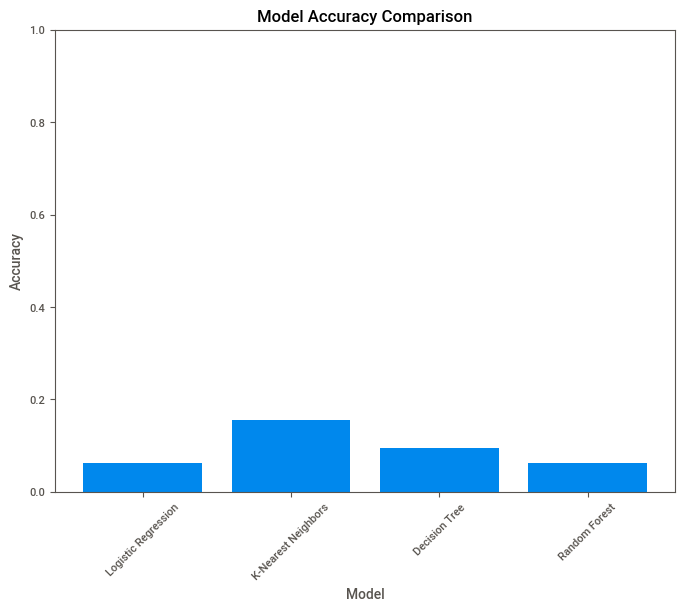

In [340]:
# Step 8: Compare Model Performance
model_names = list(results.keys())
accuracies = [results[model]['accuracy'] for model in model_names]

plt.figure(figsize=(8, 6))
plt.bar(model_names, accuracies)
plt.title('Model Accuracy Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.xticks(rotation=45)

Text(74.72222222222221, 0.5, 'Actual')

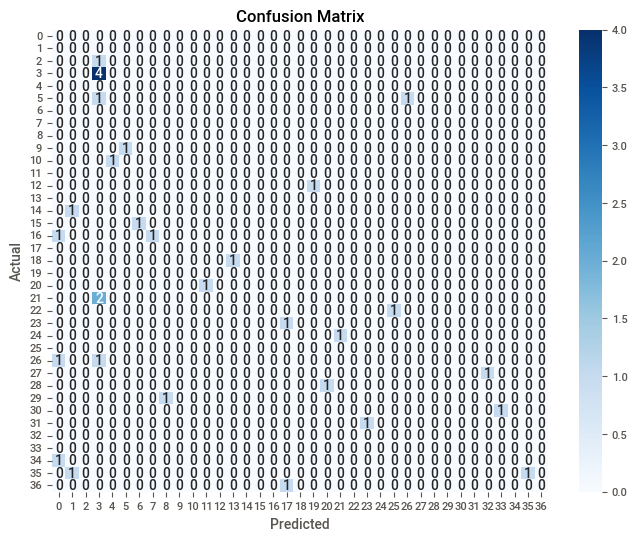

In [341]:
# plot confusion matrix for the best model with highest accuracy
best_model = results['K-Nearest Neighbors']['model']
y_pred = best_model.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

## Testing Our Prediction Model with New Data

In [344]:
new_data = pd.DataFrame({
    'Fever': ['Yes'],
    'Cough': ['No'],
    'Fatigue': ['Yes'],
    'Difficulty Breathing': ['Yes'],
    'Age': [25],
    'Gender': ['Female'],
    'Blood Pressure': ['Normal'],
    'Cholesterol Level': ['Normal']
})

# use the best model with the highest accuracy to predict the disease
best_knn_model = results['K-Nearest Neighbors']['model']
prediction = best_knn_model.predict(new_data)
print("Predicted Disease:", prediction)

Predicted Disease: ['Influenza']
